# DAE

In [1]:
import math
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.nn import functional as F
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import shutil
import logging
from tensorboardX import SummaryWriter

### Setting up the arguments

In [2]:
class Arguments:
    def __init__(self,batch_size,data_path,center_fractions,accelerations,challenge,sample_rate,resolution,resume,learning_rate,epoch,reluslope,exp_dir,checkpoint):
        self.batch_size = batch_size
        self.data_path = data_path
        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.challenge = challenge
        self.sample_rate = sample_rate
        self.resolution = resolution
        self.resume = resume
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.reluslope = reluslope
        self.exp_dir = exp_dir
        self.checkpoint = checkpoint
        
#model hyperparameters
batch_size = 1
learning_rate = 0.0001
epoch = 10
reluslope = 0.2

#other parameters
center_fractions = [0.08, 0.04]
accelerations = [4, 8]
challenge = 'singlecoil'
sample_rate = 1.
resolution = 320

data_path = 'DATA'
resume = False
checkpoint = 'DAEcheckpoint/best_model.pt'
exp_dir = 'DAEcheckpoint'
        
args=Arguments(batch_size,data_path,center_fractions,accelerations,challenge,sample_rate,resolution,resume,learning_rate,epoch,reluslope,exp_dir,checkpoint)

### Custom dataset class

In [3]:
import pathlib
import random

import h5py
from torch.utils.data import Dataset


class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(self, root, transform, challenge, sample_rate=1):
        """
        Args:
            root (pathlib.Path): Path to the dataset.
            transform (callable): A callable object that pre-processes the raw data into
                appropriate form. The transform function should take 'kspace', 'target',
                'attributes', 'filename', and 'slice' as inputs. 'target' may be null
                for test data.
            challenge (str): "singlecoil" or "multicoil" depending on which challenge to use.
            sample_rate (float, optional): A float between 0 and 1. This controls what fraction
                of the volumes should be loaded.
        """
        if challenge not in ('singlecoil', 'multicoil'):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        self.transform = transform
        self.recons_key = 'reconstruction_esc' if challenge == 'singlecoil' \
            else 'reconstruction_rss'

        self.examples = []
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            kspace = h5py.File(fname, 'r')['kspace']
            num_slices = kspace.shape[0]
            self.examples += [(fname, slice) for slice in range(num_slices)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        fname, slice = self.examples[i]
        with h5py.File(fname, 'r') as data:
            kspace = data['kspace'][slice]
            target = data[self.recons_key][slice] if self.recons_key in data else None
            return self.transform(kspace,fname.name,target)


### Data Transform (return original and masked kspace)

In [4]:
from data import transforms
class DataTransform:
    """
    Data Transformer for training DAE.
    """

    def __init__(self, mask_func, use_seed=True):
        self.mask_func = mask_func
        self.use_seed = use_seed

    def __call__(self, kspace, fname, target):
        original_kspace = transforms.to_tensor(kspace)
        # Apply mask
        seed = None if not self.use_seed else tuple(map(ord, fname))
        masked_kspace, mask = transforms.apply_mask(original_kspace, self.mask_func, seed)
        
         # Inverse Fourier Transform to get zero filled solution
        image = transforms.ifft2(masked_kspace)
        # Crop input image
        image = transforms.complex_center_crop(image, (args.resolution, args.resolution))
        # Absolute value
        image = transforms.complex_abs(image)
        # Apply Root-Sum-of-Squares if multicoil data
        if args.challenge == 'multicoil':
            image = transforms.root_sum_of_squares(image)
        # Normalize input
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        
        target = transforms.to_tensor(target)
        # Normalize target
        target = transforms.normalize(target, mean, std, eps=1e-11)
        target = target.clamp(-6, 6)
        
        return original_kspace, masked_kspace, target, mask

### Creating data loaders

In [5]:
from common.subsample import MaskFunc
from torch.utils.data import DataLoader
def create_datasets(args):
    train_mask = MaskFunc(args.center_fractions, args.accelerations)
    dev_mask = MaskFunc(args.center_fractions, args.accelerations)

    train_data = SliceData(
        root= args.data_path + '/singlecoil_train',
        transform=DataTransform(train_mask),
        sample_rate=args.sample_rate,
        challenge=args.challenge
    )
    dev_data = SliceData(
        root= args.data_path + '/singlecoil_val',
        transform=DataTransform(dev_mask, use_seed=True),
        sample_rate=args.sample_rate,
        challenge=args.challenge,
    )
    return dev_data, train_data


def create_data_loaders(args):
    dev_data, train_data = create_datasets(args)
    
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True, 
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        pin_memory=True,
    )
    return train_loader, dev_loader

train_loader, dev_loader = create_data_loaders(args)    

#### Some utility function

In [6]:
import matplotlib.pyplot as plt

def kspacetoimage(kspace):
    # Inverse Fourier Transform to get zero filled solution
    image = transforms.ifft2(kspace)
        # Crop input image
    image = transforms.complex_center_crop(image, (args.resolution, args.resolution))
        # Absolute value
    image = transforms.complex_abs(image)
        # Apply Root-Sum-of-Squares if multicoil data
    if args.challenge == 'multicoil':
        image = transforms.root_sum_of_squares(image)
        # Normalize input
    image, mean, std = transforms.normalize_instance(image, eps=1e-11)
    image = image.clamp(-6, 6)

    return image

def plotimage(image):
    plt.imshow(np.array(image))
    plt.show()
    
def transformshape(kspace):
    s = kspace.shape
    kspace = np.reshape(kspace , (s[0],s[3],s[1],s[2]))
#     s = kspace.shape
#     if (s[3]/2)%2==1:
#         npad = ((0, 0), (0, 0), (0, 0), (1, 1))
#         kspace = np.pad(kspace, pad_width=npad, mode='constant', constant_values=0)
#     if isinstance(kspace, np.ndarray):
#         kspace = transforms.to_tensor(kspace)
    return kspace

def transformback(kspace):
    s = kspace.shape
    kspace = np.reshape(kspace , (s[0],s[2],s[3],s[1]))
    return kspace

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compare_images(imageA, imageB,imageC,writer,iteration):
    mb = mse(imageA, imageB)
    sb = ssim(imageA, imageB)
    mc = mse(imageA, imageC)
    sc = ssim(imageA, imageC)

    fig = plt.figure()
    plt.suptitle("Target vs network MSE: %.2f, SSIM: %.2f" % (mb, sb)+" Target vs Zeroimputed MSE: %.2f, SSIM: %.2f" % (mc, sc))
     
    ax = fig.add_subplot(2, 2, 1)
    plt.imshow(imageA)
    plt.axis("off")

    ax = fig.add_subplot(2, 2, 2)
    plt.imshow(imageB)
    plt.axis("off")
    
    ax = fig.add_subplot(2, 2, 3)
    plt.imshow(imageA)
    plt.axis("off")

    ax = fig.add_subplot(2, 2, 4)
    plt.imshow(imageC)
    plt.axis("off")
    
    plt.show()
    writer.add_figure('Comparision', fig, global_step = iteration)    

def compareimageoutput(target,masked_kspace,outputkspace,mask,writer,iteration):
    unmask = np.where(mask==1.0, 0.0, 1.0)
    unmask = transforms.to_tensor(unmask)
    unmask = unmask.float()
    output = transformback(outputkspace.data.cpu())
    output = output * unmask
    output = output + masked_kspace.data.cpu()
    imageA = np.array(target)[0]
    imageB = np.array(kspacetoimage(output))[0]
    imageC = np.array(kspacetoimage(masked_kspace.data.cpu()))[0]
    compare_images(imageA,imageB,imageC,writer,iteration)

def onormalize(original_kspace, mean, std, eps=1e-11):
    #getting image from masked data
    image = transforms.ifft2(original_kspace)
    #normalizing the image
    nimage = transforms.normalize(image, mean, std, eps=1e-11)
    #getting kspace data from normalized image
    original_kspace_fni = transforms.ifftshift(nimage, dim=(-3, -2))
    original_kspace_fni = torch.fft(original_kspace_fni, 2)
    original_kspace_fni = transforms.fftshift(original_kspace_fni, dim=(-3, -2)) 
    original_kspace_fni = transforms.normalize(original_kspace, mean, std, eps=1e-11)
    return original_kspace_fni

def mnormalize(masked_kspace):
    #getting image from masked data
    image = transforms.ifft2(masked_kspace)
    #normalizing the image
    nimage, mean, std = transforms.normalize_instance(image, eps=1e-11)
    #getting kspace data from normalized image
    maksed_kspace_fni = transforms.ifftshift(nimage, dim=(-3, -2))
    maksed_kspace_fni = torch.fft(maksed_kspace_fni, 2)
    maksed_kspace_fni = transforms.fftshift(maksed_kspace_fni, dim=(-3, -2))
    maksed_kspace_fni, mean, std = transforms.normalize_instance(masked_kspace, eps=1e-11)
    return maksed_kspace_fni,mean,std

def nkspacetoimage(kspace_fni, mean, std, eps=1e-11):
    #nkspace to image
    assert kspace_fni.size(-1) == 2
    image = transforms.ifftshift(kspace_fni, dim=(-3, -2))
    image = torch.ifft(image, 2)
    image = transforms.fftshift(image, dim=(-3, -2))
    #denormalizing the nimage
    image = (image * std)+mean
    image = image[0]
    
    image = transforms.complex_center_crop(image, (args.resolution, args.resolution))
    # Absolute value
    image = transforms.complex_abs(image)
    # Normalize input
    image, mean, std = transforms.normalize_instance(image, eps=1e-11)
    image = image.clamp(-6, 6)
    return image

def normalize(data):
    a = np.array(data[0,:,:,0])**2 + np.array(data[0,:,:,1])**2
    divisor = math.sqrt(a.max())
    data = data/divisor
    return data,divisor

def save_model(args, exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'args': args,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_val_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir + '/model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir + '/model.pt', exp_dir + '/best_model.pt')
    
def load_model(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    autoencoder = DenoisingAutoencoder().cuda()
    autoencoder.load_state_dict(checkpoint['model'])
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.learning_rate)
    optimizer.load_state_dict(checkpoint['optimizer'])
    return checkpoint, autoencoder, optimizer

# DAE

In [7]:
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
                                                            # 640 x 386 x 2 (input)  476160 activations
        #Conv2d(in_channels, out_channels, kernel_size,padding) 
        self.conv1e = nn.Conv2d(2, 14, 51, padding=25)        # 640 x 386 x 14
        self.conv2e = nn.Conv2d(14, 28, 51, padding=25)       # 640 x 386 x 28
        self.mpl1   = nn.MaxPool2d(2)  # 320 x 186 x 28
        self.conv3e = nn.Conv2d(28, 56, 51, padding=25)       # 320 x 193 x 56
        self.mpl2   = nn.MaxPool2d(2)  # 160 x 93 x 56     833280 activations
        
        self.conv4d = nn.ConvTranspose2d(56, 28, 51, padding=25)            # 320 x 192 x 28
        
        self.conv5d = nn.ConvTranspose2d(28, 14, 51, padding=25)            # 640 x 384 x 14   
        
        self.conv6d = nn.ConvTranspose2d(14, 2, 51, padding=25)             # 640 x 384 x 2
        
        self.conv7d = nn.ConvTranspose2d(14, 2, 51, padding=(25,23))             # 640 x 386 x 2
        
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.leaky_relu(x,negative_slope=args.reluslope)
        
        x = self.conv2e(x)
        x = F.leaky_relu(x,negative_slope=args.reluslope)
        
        x = self.mpl1(x)
        
        x = self.conv3e(x)
        x = F.leaky_relu(x,negative_slope=args.reluslope)
        
        temp = x.shape[3]
        x = self.mpl2(x)
        
        # Decoder
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv4d(x)
        x = F.leaky_relu(x,negative_slope=args.reluslope)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv5d(x)
        x = F.leaky_relu(x,negative_slope=args.reluslope)
        
        if temp%2==0:
            x = self.conv6d(x)
        else:
            x = self.conv7d(x)
        
        x = F.leaky_relu(x,negative_slope=args.reluslope)
        
        return x
    
autoencoder = DenoisingAutoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=args.learning_rate)

In [8]:
print("Model's state_dict:")
for param_tensor in autoencoder.state_dict():
    print(param_tensor, "\t", autoencoder.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])


Model's state_dict:
conv1e.weight 	 torch.Size([14, 2, 51, 51])
conv1e.bias 	 torch.Size([14])
conv2e.weight 	 torch.Size([28, 14, 51, 51])
conv2e.bias 	 torch.Size([28])
conv3e.weight 	 torch.Size([56, 28, 51, 51])
conv3e.bias 	 torch.Size([56])
conv4d.weight 	 torch.Size([56, 28, 51, 51])
conv4d.bias 	 torch.Size([28])
conv5d.weight 	 torch.Size([28, 14, 51, 51])
conv5d.bias 	 torch.Size([14])
conv6d.weight 	 torch.Size([14, 2, 51, 51])
conv6d.bias 	 torch.Size([2])
conv7d.weight 	 torch.Size([14, 2, 51, 51])
conv7d.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [140199734379432, 140199734379648, 140199734379720, 140199734379792, 140199734379864, 140199734379936, 140199734380008, 140199734380080, 140199734380152, 140199734380224, 140199734380296, 140199734380368, 140199734380440, 140199734380512]}]


### Normalized

In [10]:
writer = SummaryWriter(log_dir=args.exp_dir+'/summary')
valid_loss=[]
train_loss=[]
print('Total number of epochs:', args.epoch)
print('Total number of training iterations: ',len(train_loader))
print('Total number of validation iterations: ',len(dev_loader))

if args.resume:
    checkpoint, autoencoder, optimizer = load_model(args.checkpoint)
    args = checkpoint['args']
    best_val_loss = checkpoint['best_val_loss']
    start_epoch = checkpoint['epoch']
    del checkpoint
else:
    best_val_loss = 1e9
    start_epoch = 0

for i in range(start_epoch,args.epoch):
    print("Epoch: ",i+1)
    # model training
    total_loss = 0.0
    total_val_loss = 0.0
    global_step = i * len(train_loader)
    
    autoencoder.train()
    for j,data in enumerate(train_loader):
        original_kspace,masked_kspace,target, mask = data
        #normalizing the kspace
        nmasked_kspace,mdivisor = normalize(masked_kspace)
        noriginal_kspace,odivisor = normalize(original_kspace)
        
        #transforming the input according dimention and type 
        noriginal_kspace,nmasked_kspace = transformshape(noriginal_kspace), transformshape(nmasked_kspace)
        nmasked_kspace = Variable(nmasked_kspace).cuda()
        noriginal_kspace = Variable(noriginal_kspace).cuda()
        
        #setting up all the gradients to zero
        optimizer.zero_grad()
        
        #forward pass
        outputkspace = autoencoder(nmasked_kspace)        
        #finding the loss
        loss = loss_func(outputkspace, noriginal_kspace)
        #backward pass
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            avg_loss = loss.data.item()/(j+1)
            print('Avg training loss: ',avg_loss,' Training loss: ',loss.data.item(), ' iteration :', j+1)
            
        if j % 1000 == 0:
            compareimageoutput(target,masked_kspace,outputkspace,mask,writer,global_step + j+1)
        
        total_loss += loss.data.item()
        writer.add_scalar('TrainLoss', loss.data.item()*1000, global_step + j+1)
        
    train_loss.append(total_loss/len(train_loader))
    
    # validation loss
    
    autoencoder.eval()
    for j,data in enumerate(dev_loader):
        original_kspace,masked_kspace,target, mask = data
        #normalizing the kspace
        nmasked_kspace,mdivisor = normalize(masked_kspace)
        noriginal_kspace,odivisor = normalize(original_kspace)
        
        #transforming the input according dimention and type 
        noriginal_kspace,nmasked_kspace = transformshape(noriginal_kspace), transformshape(nmasked_kspace)
        nmasked_kspace = Variable(nmasked_kspace).cuda()
        noriginal_kspace = Variable(noriginal_kspace).cuda()
        
        #forward pass
        outputkspace = autoencoder(nmasked_kspace)        
        #finding the loss
        loss = loss_func(outputkspace, noriginal_kspace)
        
        writer.add_scalar('ValidationLoss', loss.data.item()*1000, global_step + j+1)
        
        if (j) % 1000 == 0:
            avg_loss = loss.data.item()/(j+1)
            print('Avg ValidationLoss loss: ',avg_loss,' Validation loss: ',loss.data.item(), ' iteration :', j+1)
            
        if (j) % 1000 == 0:
            compareimageoutput(target,masked_kspace,outputkspace,mask,writer,global_step + j+1)
        
        total_val_loss += loss.data.item()

    valid_loss.append(total_val_loss / len(dev_loader))
    
    print('saving')
    is_new_best = valid_loss[-1] < best_val_loss
    best_val_loss = min(best_val_loss, valid_loss[-1])
    print("best val loss :",best_val_loss)
    save_model(args, args.exp_dir, i, autoencoder, optimizer, best_val_loss, is_new_best)
writer.close()


Total number of epochs: 10
Total number of training iterations:  34742
Total number of validation iterations:  7135
Epoch:  1
Avg training loss:  1.2140030776208732e-05  Training loss:  1.2140030776208732e-05  iteration : 1


KeyboardInterrupt: 

### Lossless conversion

/usr/local/lib/python3.6/dist-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


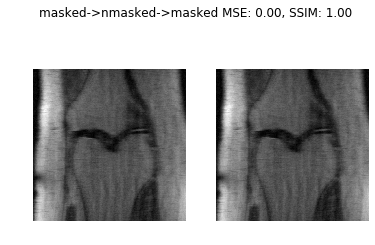

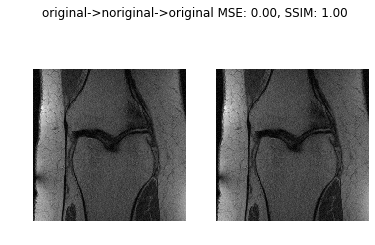

In [29]:
a1 = kspacetoimage(original_kspace.data.cpu())[0] 
a = kspacetoimage(masked_kspace.data.cpu())[0]
masked_kspace_fni,mean,std = mnormalize(masked_kspace.data.cpu())
d = nkspacetoimage(masked_kspace_fni, mean, std)
compare_images(np.array(a),np.array(d),'masked->nmasked->masked')
original_kspace_fni = onormalize(original_kspace,mean,std)
d = nkspacetoimage(original_kspace_fni, mean, std)
compare_images(np.array(a1),np.array(d),'original->noriginal->original')

# The code below is just for personal use

In [61]:
np.savetxt('originalkspace_a.txt', original_kspace[0,:,:,0])
np.savetxt('originalkspace_b.txt', original_kspace[0,:,:,1])

In [ ]:
i = original_kspace[0,:,:,0]
p = original_kspace[0,:,:,1]
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

i = noriginal_kspace[0,0,:,:]
p = noriginal_kspace[0,1,:,:]
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

i = masked_kspace[0,0,:,:].data.cpu()
p = masked_kspace[0,1,:,:].data.cpu()
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

i = nmasked_kspace[0,0,:,:].data.cpu()
p = nmasked_kspace[0,1,:,:].data.cpu()
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

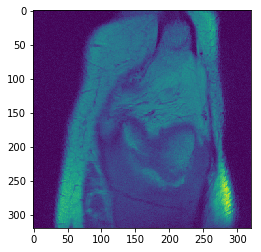

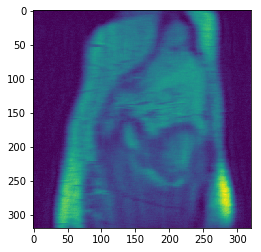

In [218]:
noriginal_kspace, odivisor = normalize(original_kspace)
plotimage(kspacetoimage(noriginal_kspace)[0])
nmasked_kspace, mdivisor = normalize(masked_kspace)
plotimage(kspacetoimage(nmasked_kspace)[0])

In [249]:
outputkspace.shape

torch.Size([1, 2, 640, 384])

Epoch:  0


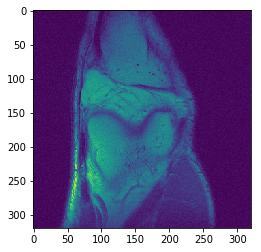

In [247]:
for i in range(epoch):
    print("Epoch: ",i)
    # model training
    total_loss = 0.0
    total_iter = 0

    autoencoder.train()
    for i,data in enumerate(train_loader):
        noriginal_kspace,nmasked_kspace,target, mask = data
        plotimage(kspacetoimage(noriginal_kspace)[0])
        nmasked_kspace = nmasked_kspace[:,:,0:384,:]
        #transforming the input according dmention and type 
        noriginal_kspace,nmasked_kspace = transformshape(noriginal_kspace), transformshape(nmasked_kspace)
        nmasked_kspace = Variable(nmasked_kspace).cuda()
        noriginal_kspace = Variable(noriginal_kspace).cuda()
        
        #forward pass
        outputkspace = autoencoder(nmasked_kspace)  
        break
    break

In [ ]:
unmask = np.where(mask==1.0, 0.0, 1.0)
unmask = transforms.to_tensor(unmask)
unmask = unmask.float()
output = transformback(outputkspace.data.cpu())

list(autoencoder.parameters())

list(autoencoder.parameters())

train_loss = []
valid_loss = []
print('Total number of epochs:', epoch)
print('Total number of training iterations: ',len(train_loader))
print('Total number of validation iterations: ',len(dev_loader))

for i in range(epoch):
    print("Epoch: ",i)
    # model training
    total_loss = 0.0
    total_iter = 0

    autoencoder.train()
    for i,data in enumerate(train_loader):
        original_kspace,masked_kspace,target, mask = data
        original_width = original_kspace.shape[2]
        
        inputdata = Variable(transformshape(original_kspace)).cuda()
        masked_kspace = Variable(transformshape(masked_kspace)).cuda()
        optimizer.zero_grad()
        
        outputdata = autoencoder(masked_kspace)
        plotimage(kspacetoimage(original_kspace))
        break
    break

plt.plot(np.unique(np.array(noriginal_kspace.data.cpu())))

np.unique(np.array(outputkspace.data.cpu()))

outputkspace = autoencoder(nmasked_kspace)

loss_func(outputkspace, noriginal_kspace)

compareimageoutput(target,masked_kspace,outputkspace,mask)

In [ ]:
plotimage(kspacetoimage(transforms.to_tensor(transformback(transformshape(outputdata)[:,:,:,1:1+original_width]))))
max=0
v=0
for i,data in enumerate(train_loader):
    original_kspace,masked_kspace,target, mask = data
    s = original_kspace.shape
    if s[2]>max:
        max = s[2]
        v = s
print(max)
print(v)
plt.imshow(np.array(masked_kspace[0,250:400,150:250,0]))
plt.show()
plt.imshow(np.array(original_kspace[0,250:400,150:250,0]))
plt.show()
print(np.array(mask).shape)

In [ ]:
# Save the model
torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import random

img, _ = random.choice(cifar10_valid)
img    = img.resize_((1, 3, 32, 32))
noise  = torch.randn((1, 3, 32, 32)) * noise_level
img_n  = torch.add(img, noise)

img_n = Variable(img_n).cuda()
denoised = autoencoder(img_n)


show_img(img[0].numpy(), img_n[0].data.cpu().numpy(), denoised[0].data.cpu().numpy())

# Visualize the first image of the last batch in our validation set
    orig = image[0].cpu()
    noisy = image_n[0].cpu()
    denoised = output[0].cpu()

    orig = orig.data.numpy()
    noisy = noisy.data.numpy()
    denoised = denoised.data.numpy()

    print("Iteration ", i+1)
    show_img(orig, noisy, denoised)

In [ ]:
learning_rate = 0.001
epoch = 10
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
                                                            # 640 x 372 x 2 (input)  476160 activations
        self.conv1e = nn.Conv2d(2, 24, 3, padding=2)        # 640 x 372 x 24
        self.conv2e = nn.Conv2d(24, 48, 3, padding=2)       # 640 x 372 x 48
        self.conv3e = nn.Conv2d(48, 96, 3, padding=2)       # 640 x 372 x 96
        self.conv4e = nn.Conv2d(96, 128, 3, padding=2)      # 640 x 372 x 128
        self.conv5e = nn.Conv2d(128, 256, 3, padding=2)     # 640 x 372 x 256
        self.mp1e   = nn.MaxPool2d(2, return_indices=True)  # 640 x 372 x 256       60948480 acivations

        self.mp1d = nn.MaxUnpool2d(2)
        self.conv5d = nn.ConvTranspose2d(256, 128, 3, padding=2)
        self.conv4d = nn.ConvTranspose2d(128, 96, 3, padding=2)
        self.conv3d = nn.ConvTranspose2d(96, 48, 3, padding=2)
        self.conv2d = nn.ConvTranspose2d(48, 24, 3, padding=2)
        self.conv1d = nn.ConvTranspose2d(24, 3, 2, padding=2)
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        x = self.conv2e(x)
        x = F.relu(x)
        x = self.conv3e(x)
        x = F.relu(x)
        x = self.conv4e(x)
        x = F.relu(x)
        x = self.conv5e(x)
        x = F.relu(x)
        x, i = self.mp1e(x)
        
         # Decoder
        x = self.mp1d(x, i)
        x = self.conv5d(x)
        x = F.relu(x)
        x = self.conv4d(x)
        x = F.relu(x)
        x = self.conv3d(x)
        x = F.relu(x)
        x = self.conv2d(x)
        x = F.relu(x)
        x = self.conv1d(x)
        x = F.relu(x)
        
        return x

autoencoder = DenoisingAutoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

self.conv1e = nn.Conv2d(2, 14, 3, padding=1)        # 640 x 372 x 14
        self.conv2e = nn.Conv2d(14, 28, 3, padding=1)       # 640 x 372 x 28
        self.mpl1   = nn.MaxPool2d(2, return_indices=True)  # 320 x 186 x 28
        self.conv3e = nn.Conv2d(28, 56, 3, padding=1)       # 320 x 186 x 56
        self.mpl2   = nn.MaxPool2d(2, return_indices=True)  # 160 x 93 x 56     833280 activations
        
        self.conv4d = nn.ConvTranspose2d(56, 28, 3, padding=1)            # 320 x 186 x 28
        self.conv5d = nn.ConvTranspose2d(28, 14, 3, padding=1)            # 640 x 372 x 14   
        self.conv6d = nn.ConvTranspose2d(14, 2, 3, padding=1)             # 640 x 372 x 2
        
        def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        
        x = self.conv2e(x)
        x = F.relu(x)
        
        x, i = self.mpl1(x)
        
        x = self.conv3e(x)
        x = F.relu(x)
        
        x, j = self.mpl2(x)
        
        # Decoder
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv4d(x)
        x = F.relu(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv5d(x)
        x = F.relu(x)
        
        x = self.conv6d(x)
        x = F.relu(x)
        
        return x

def explainmasking():
    masked = original_kspace*mask
    maskedt = original_kspace*unmask
    total = masked + maskedt
    plotimage(kspacetoimage(masked))
    plotimage(kspacetoimage(maskedt))
    plotimage(kspacetoimage(total))